In [3]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [4]:
from qiskit_optimization.applications import Maxcut, Tsp

In [5]:
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)

In [6]:
import networkx as nx
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [7]:
nx.random_geometric_graph?

Signature: nx.random_geometric_graph(n, radius, dim=2, pos=None, p=2, seed=None)
Docstring:
Returns a random geometric graph in the unit cube of dimensions `dim`.

The random geometric graph model places `n` nodes uniformly at
random in the unit cube. Two nodes are joined by an edge if the
distance between the nodes is at most `radius`.

Edges are determined using a KDTree when SciPy is available.
This reduces the time complexity from $O(n^2)$ to $O(n)$.

Parameters
----------
n : int or iterable
    Number of nodes or iterable of nodes
radius: float
    Distance threshold value
dim : int, optional
    Dimension of graph
pos : dict, optional
    A dictionary keyed by node with node positions as values.
p : float, optional
    Which Minkowski distance metric to use.  `p` has to meet the condition
    ``1 <= p <= infinity``.

    If this argument is not specified, the :math:`L^2` metric
    (the Euclidean distance metric), p = 2 is used.
    This should not be confused with the `p` of an

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


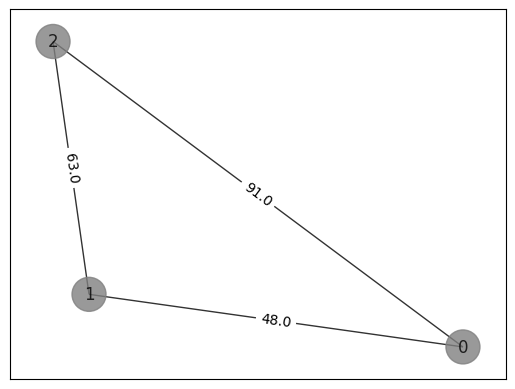

In [8]:

dj_matrix = nx.to_numpy_array(tsp.graph)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["grey" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


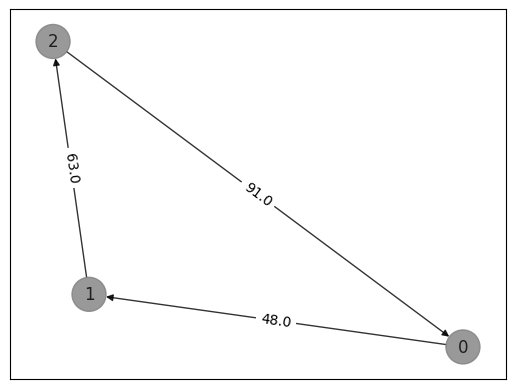

In [9]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="black", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="black", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [10]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())


Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [37]:
import math
from typing import Tuple

import numpy as np

from qiskit.opflow import I, ListOp, OperatorBase, PauliOp, PauliSumOp, SummedOp
from qiskit.quantum_info import Pauli
from qiskit_optimization.exceptions import QiskitOptimizationError
from qiskit_optimization.problems.quadratic_program import QuadraticProgram


def to_ising_1(quad_prog: QuadraticProgram) -> Tuple[OperatorBase, float]:
    """Return the Ising Hamiltonian of this problem.

    Variables are mapped to qubits in the same order, i.e.,
    i-th variable is mapped to i-th qubit.
    See https://github.com/Qiskit/qiskit-terra/issues/1148 for details.

    Args:
        quad_prog: The problem to be translated.

    Returns:
        A tuple (qubit_op, offset) comprising the qubit operator for the problem
        and offset for the constant value in the Ising Hamiltonian.

    Raises:
        QiskitOptimizationError: If an integer variable or a continuous variable exists
            in the problem.
        QiskitOptimizationError: If constraints exist in the problem.
    """
    # if problem has variables that are not binary, raise an error
    if quad_prog.get_num_vars() > quad_prog.get_num_binary_vars():
        raise QiskitOptimizationError(
            "The type of all variables must be binary. "
            "You can use `QuadraticProgramToQubo` converter "
            "to convert integer variables to binary variables. "
            "If the problem contains continuous variables, `to_ising` cannot handle it. "
            "You might be able to solve it with `ADMMOptimizer`."
        )

    # if constraints exist, raise an error
    if quad_prog.linear_constraints or quad_prog.quadratic_constraints:
        raise QiskitOptimizationError(
            "There must be no constraint in the problem. "
            "You can use `QuadraticProgramToQubo` converter "
            "to convert constraints to penalty terms of the objective function."
        )

    # initialize Hamiltonian.
    num_nodes = quad_prog.get_num_vars()
    pauli_list = []
    offset = 0.0
    zero = np.zeros(num_nodes, dtype=bool)

    # set a sign corresponding to a maximized or minimized problem.
    # sign == 1 is for minimized problem. sign == -1 is for maximized problem.
    sense = quad_prog.objective.sense.value
    print(quad_prog)
    print(quad_prog.objective)
    print(quad_prog.objective.sense)
    print(sense)

    # convert a constant part of the objective function into Hamiltonian.
    print(quad_prog.objective.constant)
    offset += quad_prog.objective.constant * sense
    print(offset)
    print('linear part of the hamiltonian')
    print(quad_prog.objective.linear.to_dict())

    # convert linear parts of the objective function into Hamiltonian.
    for idx, coef in quad_prog.objective.linear.to_dict().items():
        z_p = zero.copy()
        weight = coef * sense / 2
        z_p[idx] = True #

        pauli_list.append(PauliOp(Pauli((z_p, zero)), -weight))
        offset += weight
    print(offset)

    # create Pauli terms
    for (i, j), coeff in quad_prog.objective.quadratic.to_dict().items():
        weight = coeff * sense / 4

        if i == j:
            offset += weight
        else:
            z_p = zero.copy()
            z_p[i] = True
            z_p[j] = True
            pauli_list.append(PauliOp(Pauli((z_p, zero)), weight))

        z_p = zero.copy()
        z_p[i] = True
        pauli_list.append(PauliOp(Pauli((z_p, zero)), -weight))

        z_p = zero.copy()
        z_p[j] = True
        pauli_list.append(PauliOp(Pauli((z_p, zero)), -weight))

        offset += weight

    # Remove paulis whose coefficients are zeros.
    qubit_op = sum(pauli_list)

    # qubit_op could be the integer 0, in this case return an identity operator of
    # appropriate size
    if isinstance(qubit_op, OperatorBase):
        qubit_op = qubit_op.reduce()
    else:
        # If there is no variable, we set num_nodes=1 so that qubit_op should be an operator.
        # If num_nodes=0, I^0 = 1 (int).
        num_nodes = max(1, num_nodes)
        qubit_op = 0 * I ^ num_nodes

    return qubit_op, offset

120 - 40 x00^2 + 80 x00 x01 - 60 x01^2 + 80 x00 x02 + 80 x01 x02 - 
 60 x02^2 + 48 x01 x10 + 48 x02 x10 - 20 x10^2 + 48 x00 x11 + 
 40 x01 x11 + 48 x02 x11 + 40 x10 x11 - 40 x11^2 + 48 x00 x12 + 
 48 x01 x12 + 40 x02 x12 + 40 x10 x12 + 40 x11 x12 - 40 x12^2 + 
 91 x01 x20 + 91 x02 x20 + 63 x12 x20 - 20 x20^2 + 91 x00 x21 + 
 40 x01 x21 + 91 x02 x21 + 63 x10 x21 + 40 x11 x21 + 103 x20 x21 - 
 40 x21^2 + 91 x00 x22 + 91 x01 x22 + 40 x02 x22 + 63 x11 x22 + 
 40 x12 x22 + 103 x20 x22 + 103 x21 x22 - 40 x22^2

In [ ]:
- 40 x00^2

40*x_0_0^2 + 40*x_0_0*x_0_1 + 40*x_0_0*x_0_2 + 40*x_0_0*x_1_0 + 48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 40*x_0_0*x_2_0 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2 + 40*x_0_1^2 + 40*x_0_1*x_0_2 + 48*x_0_1*x_1_0 + 40*x_0_1*x_1_1 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 40*x_0_1*x_2_1 + 91*x_0_1*x_2_2 + 40*x_0_2^2 + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 40*x_0_2*x_1_2 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1 + 40*x_0_2*x_2_2 + 40*x_1_0^2 + 40*x_1_0*x_1_1 + 40*x_1_0*x_1_2 + 40*x_1_0*x_2_0 + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 40*x_1_1^2 + 40*x_1_1*x_1_2 + 63*x_1_1*x_2_0 + 40*x_1_1*x_2_1 + 63*x_1_1*x_2_2 + 40*x_1_2^2 + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1 + 40*x_1_2*x_2_2 + 40*x_2_0^2 + 40*x_2_0*x_2_1 + 40*x_2_0*x_2_2 + 40*x_2_1^2 + 40*x_2_1*x_2_2 + 40*x_2_2^2 - 80*x_0_0 - 80*x_0_1 - 80*x_0_2 - 80*x_1_0 - 80*x_1_1 - 80*x_1_2 - 80*x_2_0 - 80*x_2_1 - 80*x_2_2 + 120

In [38]:
to_ising_1(qubo)


minimize 240*x_0_0^2 + 240*x_0_0*x_0_1 + 240*x_0_0*x_0_2 + 240*x_0_0*x_1_0 + 48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 240*x_0_0*x_2_0 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2 + 240*x_0_1^2 + 240*x_0_1*x_0_2 + 48*x_0_1*x_1_0 + 240*x_0_1*x_1_1 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 240*x_0_1*x_2_1 + 91*x_0_1*x_2_2 + 240*x_0_2^2 + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 240*x_0_2*x_1_2 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1 + 240*x_0_2*x_2_2 + 240*x_1_0^2 + 240*x_1_0*x_1_1 + 240*x_1_0*x_1_2 + 240*x_1_0*x_2_0 + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 240*x_1_1^2 + 240*x_1_1*x_1_2 + 63*x_1_1*x_2_0 + 240*x_1_1*x_2_1 + 63*x_1_1*x_2_2 + 240*x_1_2^2 + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1 + 240*x_1_2*x_2_2 + 240*x_2_0^2 + 240*x_2_0*x_2_1 + 240*x_2_0*x_2_2 + 240*x_2_1^2 + 240*x_2_1*x_2_2 + 240*x_2_2^2 - 480*x_0_0 - 480*x_0_1 - 480*x_0_2 - 480*x_1_0 - 480*x_1_1 - 480*x_1_2 - 480*x_2_0 - 480*x_2_1 - 480*x_2_2 + 720 (9 variables, 0 constraints, 'TSP')
minimize 240*x_0_0^2 + 240*x_0_0*x_0_1 + 240*x_0_0*x_0_2 + 240*x_0_0*x_1_0 + 48*x_0_0*x

(PauliSumOp(SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIIZZI', 'IIIIIZIIZ', 'IIIIIZIZI', 'IIIIIZZII', 'IIIIZIIIZ', 'IIIIZIIZI', 'IIIIZIZII', 'IIIIZZIII', 'IIIZIIIIZ', 'IIIZIIIZI', 'IIIZIIZII', 'IIIZIZIII', 'IIIZZIIII', 'IIZIIIIIZ', 'IIZIIIIZI', 'IIZIIIZII', 'IIZIIZIII', 'IIZIZIIII', 'IIZZIIIII', 'IZIIIIIIZ', 'IZIIIIIZI', 'IZIIIIZII', 'IZIIIZIII', 'IZIIZIIII', 'IZIZIIIII', 'IZZIIIIII', 'ZIIIIIIIZ', 'ZIIIIIIZI', 'ZIIIIIZII', 'ZIIIIZIII', 'ZIIIZIIII', 'ZIIZIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
               coeffs=[-189.5 +0.j, -189.5 +0.j, -189.5 +0.j, -175.5 +0.j, -175.5 +0.j,
  -175.5 +0.j, -197.  +0.j, -197.  +0.j, -197.  +0.j,   60.  +0.j,
    60.  +0.j,   60.  +0.j,   60.  +0.j,   12.  +0.j,   12.  +0.j,
    12.  +0.j,   60.  +0.j,   12.  +0.j,   60.  +0.j,   12.  +0.j,
    12.  +0.j,   60.  +0.j,   60.  +0.j,   60.  +0.j,   60.  +0.j,
    22.75+0.j,   22.75+0.j,   6

In [12]:
string = 'IZZIIIIII'
indices = []

for i in range(len(string)):
    if string[i] == 'Z':
        indices.append(i)

print(indices)


[1, 2]


In [13]:

indices = []
for i in range(len(pauli_strings[14])):
    if pauli_strings[14][i] == 'Z':
        indices.append(i)

print(indices)

        

NameError: name 'pauli_strings' is not defined

In [36]:
pauli_strings = []
coeff = []
for i in (qubitOp):
    pauli_strings.append((str(i)[len(str(i))-9:len(str(i))]))
    coeff.append(float(str(i)[:len(str(i))-12]))
print(pauli_strings, coeff)

graph = []
Graph = []
for i in range(len(pauli_strings)):
    for j in range(len(pauli_strings[i])):
        if pauli_strings[i][j] == 'Z':
            graph.append(j)
Graph.append(graph)
print(Graph)

coeff = []
for i in (qubitOp):
    print((str(i)[:len(str(i))-12]))

['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIIZZI', 'IIIIIZIIZ', 'IIIIIZIZI', 'IIIIIZZII', 'IIIIZIIIZ', 'IIIIZIIZI', 'IIIIZIZII', 'IIIIZZIII', 'IIIZIIIIZ', 'IIIZIIIZI', 'IIIZIIZII', 'IIIZIZIII', 'IIIZZIIII', 'IIZIIIIIZ', 'IIZIIIIZI', 'IIZIIIZII', 'IIZIIZIII', 'IIZIZIIII', 'IIZZIIIII', 'IZIIIIIIZ', 'IZIIIIIZI', 'IZIIIIZII', 'IZIIIZIII', 'IZIIZIIII', 'IZIZIIIII', 'IZZIIIIII', 'ZIIIIIIIZ', 'ZIIIIIIZI', 'ZIIIIIZII', 'ZIIIIZIII', 'ZIIIZIIII', 'ZIIZIIIII', 'ZIZIIIIII', 'ZZIIIIIII'] [-189.5, -189.5, -189.5, -175.5, -175.5, -175.5, -197.0, -197.0, -197.0, 60.0, 60.0, 60.0, 60.0, 12.0, 12.0, 12.0, 60.0, 12.0, 60.0, 12.0, 12.0, 60.0, 60.0, 60.0, 60.0, 22.75, 22.75, 60.0, 15.75, 15.75, 22.75, 60.0, 22.75, 15.75, 60.0, 15.75, 60.0, 22.75, 22.75, 60.0, 15.75, 15.75, 60.0, 60.0, 60.0]
[[8, 7, 6, 5, 4, 3, 2, 1, 0, 7, 8, 6, 8, 6, 7, 5, 8, 5, 7, 5, 6, 4, 8, 4, 7, 4, 6, 4, 5, 3, 8, 3, 7, 3, 6, 3, 5, 

-1282.5
-1282.5
-1282.5
-1268.5
-1268.5
-1268.5
-1290.0
-1290.0
-1290.0
606.5
606.5
606.5
606.5
12.0
12.0
12.0
606.5
12.0
606.5
12.0
12.0
606.5
606.5
606.5
606.5
22.75
22.75
606.5
15.75
15.75
22.75
606.5
22.75
15.75
606.5
15.75
606.5
22.75
22.75
606.5
15.75
15.75
606.5
606.5
606.5


In [35]:
%%time
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo(penalty=120)
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 1023.0
Ising Hamiltonian:
-189.5 * IIIIIIIIZ
- 189.5 * IIIIIIIZI
- 189.5 * IIIIIIZII
- 175.5 * IIIIIZIII
- 175.5 * IIIIZIIII
- 175.5 * IIIZIIIII
- 197.0 * IIZIIIIII
- 197.0 * IZIIIIIII
- 197.0 * ZIIIIIIII
+ 60.0 * IIIIIIIZZ
+ 60.0 * IIIIIIZIZ
+ 60.0 * IIIIIIZZI
+ 60.0 * IIIIIZIIZ
+ 12.0 * IIIIIZIZI
+ 12.0 * IIIIIZZII
+ 12.0 * IIIIZIIIZ
+ 60.0 * IIIIZIIZI
+ 12.0 * IIIIZIZII
+ 60.0 * IIIIZZIII
+ 12.0 * IIIZIIIIZ
+ 12.0 * IIIZIIIZI
+ 60.0 * IIIZIIZII
+ 60.0 * IIIZIZIII
+ 60.0 * IIIZZIIII
+ 60.0 * IIZIIIIIZ
+ 22.75 * IIZIIIIZI
+ 22.75 * IIZIIIZII
+ 60.0 * IIZIIZIII
+ 15.75 * IIZIZIIII
+ 15.75 * IIZZIIIII
+ 22.75 * IZIIIIIIZ
+ 60.0 * IZIIIIIZI
+ 22.75 * IZIIIIZII
+ 15.75 * IZIIIZIII
+ 60.0 * IZIIZIIII
+ 15.75 * IZIZIIIII
+ 60.0 * IZZIIIIII
+ 22.75 * ZIIIIIIIZ
+ 22.75 * ZIIIIIIZI
+ 60.0 * ZIIIIIZII
+ 15.75 * ZIIIIZIII
+ 15.75 * ZIIIZIIII
+ 60.0 * ZIIZIIIII
+ 60.0 * ZIZIIIIII
+ 60.0 * ZZIIIIIII
CPU times: user 30 ms, sys: 2.73 ms, total: 32.7 ms
Wall time: 30.4 ms


In [21]:
to_ising_1(qubo)

1


(PauliSumOp(SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIIZZI', 'IIIIIZIIZ', 'IIIIIZIZI', 'IIIIIZZII', 'IIIIZIIIZ', 'IIIIZIIZI', 'IIIIZIZII', 'IIIIZZIII', 'IIIZIIIIZ', 'IIIZIIIZI', 'IIIZIIZII', 'IIIZIZIII', 'IIIZZIIII', 'IIZIIIIIZ', 'IIZIIIIZI', 'IIZIIIZII', 'IIZIIZIII', 'IIZIZIIII', 'IIZZIIIII', 'IZIIIIIIZ', 'IZIIIIIZI', 'IZIIIIZII', 'IZIIIZIII', 'IZIIZIIII', 'IZIZIIIII', 'IZZIIIIII', 'ZIIIIIIIZ', 'ZIIIIIIZI', 'ZIIIIIZII', 'ZIIIIZIII', 'ZIIIZIIII', 'ZIIZIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
               coeffs=[-89.5 +0.j, -89.5 +0.j, -89.5 +0.j, -75.5 +0.j, -75.5 +0.j, -75.5 +0.j,
  -97.  +0.j, -97.  +0.j, -97.  +0.j,  10.  +0.j,  10.  +0.j,  10.  +0.j,
   10.  +0.j,  12.  +0.j,  12.  +0.j,  12.  +0.j,  10.  +0.j,  12.  +0.j,
   10.  +0.j,  12.  +0.j,  12.  +0.j,  10.  +0.j,  10.  +0.j,  10.  +0.j,
   10.  +0.j,  22.75+0.j,  22.75+0.j,  10.  +0.j,  15.75+0.j,  15.75+0